In [127]:
from simulation_functions import index, simulation_, plot
from interpolation_functions import T_K,gradient_descent
from make_noise import simulate_noise
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [132]:


sim = simulate_noise()
ts = sim[0]
fs = sim[1] # with noise

sampling = 3
# desired sampling for each curve
tk = np.array([T_K(sampling,ts[0])[0],T_K(sampling,ts[1])[0],T_K(sampling,ts[2])[0],T_K(sampling,ts[3])[0]]) # desired sampling is 3 days here

h=sampling
time_delays = sim[2]

# sinc matrix
matrix = []
for i in range(4):
    matrix.append(np.array([(ts[i][:,np.newaxis]-time_delays[i]*100)-tk[i][np.newaxis,:]]))
matrix = np.array(matrix)

A = np.sinc(np.concatenate([matrix[0],matrix[1],matrix[2],matrix[3]],axis =0)/h) 

Y= np.concatenate([fs[0][np.newaxis,:],fs[1][np.newaxis,:],fs[2][np.newaxis,:],fs[3][np.newaxis,:]])


In [135]:
t_drive_new = np.loadtxt('t_drive_new.txt') # true time sample. 
ind = index(15,t_drive_new) # 15 means that the time delay is chosen randomly between 0 and 15 days
# getting the indices of each time shifter curve 
index0 = ind[0]
index1 = ind[1]
index2 = ind[2]
index3 = ind[3]
sample = np.sort(ind[5])

#getting the time sample of each curve
ts_0 = sample[index0]
ts_1 = sample[index1]
ts_2 = sample[index2]
ts_3 = sample[index3]
ts = np.array([ts_0,ts_1,ts_2,ts_3])

# finding the magnitudes corresponding to each time shifted sample
f = simulation_(sample) #running simulation
fs_0 = f[index0]
fs_1 = f[index1]
fs_2 = f[index2]
fs_3 = f[index3]
h=3

# desired sampling for each curve
tk_0 = T_K(h,ts_0)[0]
tk_1 = T_K(h,ts_1)[0]
tk_2 = T_K(h,ts_2)[0]
tk_3 = T_K(h,ts_3)[0]
tk = np.array([tk_0,tk_1,tk_2,tk_3])

time_delays = ind[6] 

# sinc matrix
a = np.array([(ts_0[:,np.newaxis]+time_delays[0])-tk_0[np.newaxis,:]])
b = np.array([(ts_1[:,np.newaxis]+time_delays[1])-tk_1[np.newaxis,:]])
c = np.array([(ts_2[:,np.newaxis]+time_delays[2])-tk_2[np.newaxis,:]])
d = np.array([(ts_3[:,np.newaxis]+time_delays[3])-tk_3[np.newaxis,:]])
sinc_matrix = np.sinc(np.concatenate([a,b,c,d],axis =0)/h)
#sinc_matrix.shape # 4 x s x k

B= np.concatenate([fs_0[np.newaxis,:],fs_1[np.newaxis,:],fs_2[np.newaxis,:],fs_3[np.newaxis,:]])
# B.shape # 4 x s

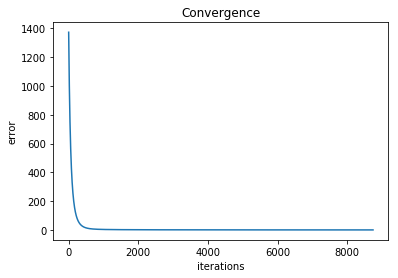

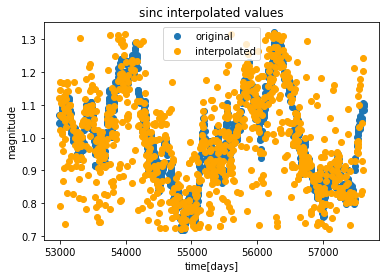

In [136]:
gradient_descent(ts_0,T_K(h,ts_0),B[0])

In [99]:
A[0].shape

(1369, 1543)

In [129]:
# multiplication functions:
#noise_std = sim[3]
def AT(X,A,Y, noise): 
    '''
    calculateS the weighted mean of A.T(Y-AX)
    input:
    X : array with shape k, solution of interpolation
    A : tensor of shape 4xkxs, sinc matrix
    Y : matrix of shape 4xs, magnitudes of original time sampling
    '''
    weighted_mean = 0
    nl, ns, nx = A.shape
    for i in range(nl):
        weighted_mean += ((1/noise[i])**2)*np.dot(A[i].T, Y[i] - A[i] @ X)/np.sum(1/(noise**2))
    
    return weighted_mean

def multiplication(X,S): # X.S
    '''
    multiplies X by S[i] and takes the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i]))
    this = np.array(this)
    return np.mean(this,axis=0)

def multiplication_T(X,S): # X.S.T

    '''
    multiplies X by S[i].T and take the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i].T))
    this = np.array(this)
    return np.mean(this,axis=0)

In [122]:
noise_std

0.0008364322354833849

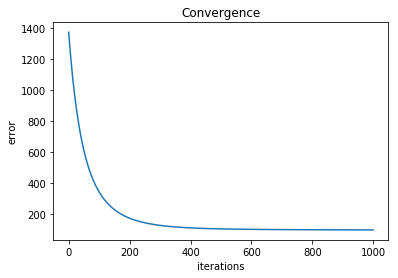

In [133]:
A = A[0]
Y = Y[0]
#noise_std = noise_std[0]
# def linorm(S, nit):
#     x0 = np.random.rand(S.shape[1])  # chose [1] per the implementation of the power iteration method in wiki
#     x0 = x0 /np.linalg.norm(x0)
#     for i in range(nit):
#         x = multiplication(x0,S)#np.dot(x0,S)
#         xn = np.linalg.norm(x)
#         xp = x / xn#     
#         y = multiplication_T(xp,S) # the S.T is done within the functionas S[i].T not S.T[i]
#         yn = np.linalg.norm(y)  
#         x0 = y / yn
#     return 1./xn
# mu = linorm(A,20)/170 # = 0.0038
mu = 0.006
X = np.zeros(len(tk[0]))

count = 0
R = [np.sum(Y ** 2)]
epsilon = 0.3


while (R[-1] > epsilon) and (
        count < 1000):  # 5000 is a good amount of counts
#     if count % 100 == 0:
#         print('iteration {}'.format(count))
    X_new = X + mu * np.dot(A.T,Y-A@X)#AT(X,A,Y, noise_std)
    X = X_new.copy()
    R.append(np.sum((Y - A @ X) ** 2.))
    count += 1


plt.title('Convergence')
plt.plot(np.array(R[1:]))
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()




In [95]:
X.T == X

array([ True,  True,  True, ...,  True,  True,  True])

In [78]:
A[0].T.shape

(1543, 1369)

In [74]:
Y.shape

(1369,)

[[52992 52995 52998 ... 57614 57617 57621]
 [52993 52996 52999 ... 57616 57619 57623]
 [52998 53001 53004 ... 57621 57624 57628]
 [52993 52996 52999 ... 57615 57618 57622]]


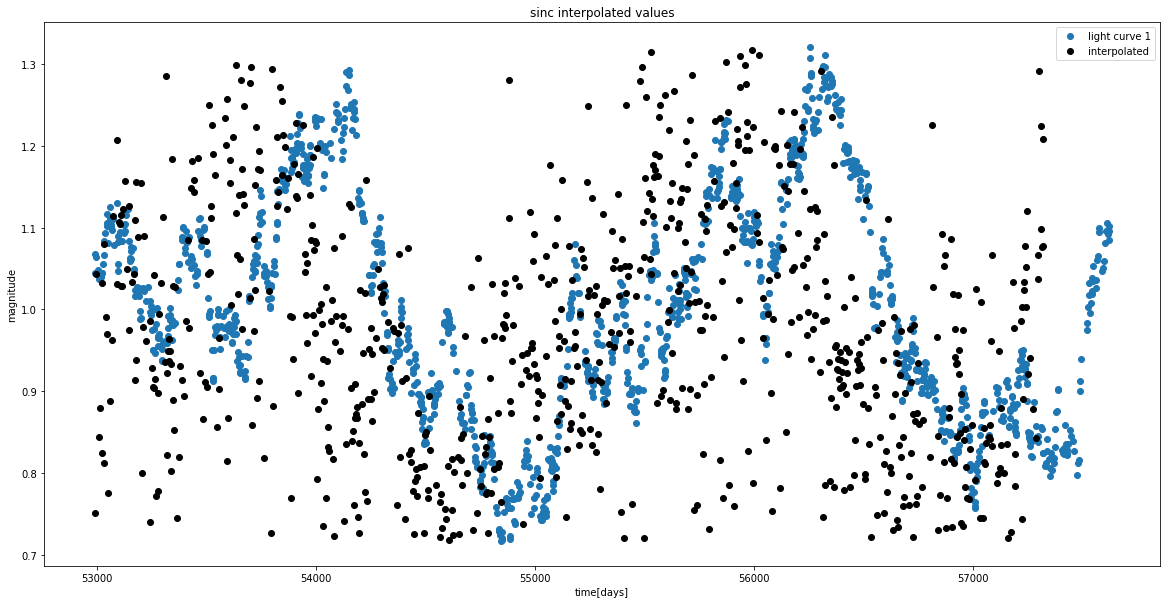

In [134]:
cut = np.logical_and(X < np.max(Y), X > np.min(Y))

plt.figure(figsize=(20,10))
plt.plot(ts[0], Y, 'o', label='light curve 1')

# plt.plot(ts[0], Y[0], 'o', label='light curve 1')
# plt.plot(ts[1], Y[1], 'o', label='light curve 2')
# plt.plot(ts[2], Y[2], 'o', label='light curve 3')
# plt.plot(ts[3], Y[3], 'o', label='light curve 4')

print(tk)

plt.plot(tk[0][cut], X[cut],'o', label='interpolated', color='black')
plt.xlabel('time[days]')
plt.ylabel('magnitude')
plt.title('sinc interpolated values')
plt.legend()
plt.savefig("figures/result_4xkxs_final.png")
plt.show()


<Figure size 432x288 with 0 Axes>

wondering about: (to discuss in meeting)
- multiplication_T(X,S): X,S[i].T versus X,S.T[i]
- interpolation is not that good, /draft/4xkxs.py seems to interpolate better.
- we agreed that the standard deviation of the distribution of noise added to the data would be about the tenth
  of the power of the signal (sqrt(f1^2+f2^2+...)) but this standard deviation turns out to be way too large, especially compared to the noise from the real data which I took inspiration from to make the noise for the simulated data.


In [23]:
Y.shape

()